# Effects of Different Parameters on Sleep Quality

#### Ece Kunduracıoğlu 21727523
#### Ece Korkmaz 21827627


Our main goal is to analyze the effect of different parameters on sleep quality. Some of these parameters are medication usage, diseases a patient has, age, gender, BMI and heart rate along with oxygen saturation during sleep. Different stages of sleep such as REM and 3 steps of NREM will be considered.

## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

In healthcare, sleep quality is undoubtedly an important factor. The quality of our sleep directly affects our daily life, hence there is lots of work in this topic which was done by both physicians and data scientists. Considering the importance of the field, we decided to work on sleep monitoring. Our main goal is to analyze the effect of different parameters on sleep quality. We examine the effects of different diseases, problems, medications, and gender on the sleep quality. We used sleep stages to understand the sleep quality of the patients.

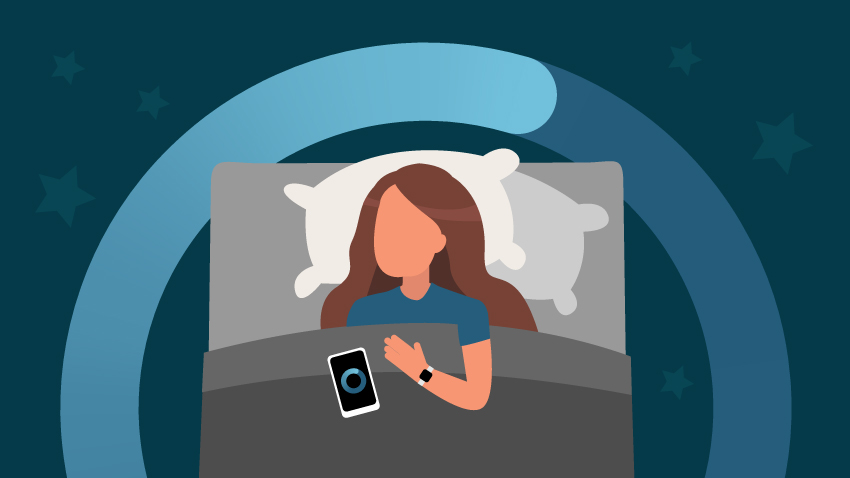

## Data Understanding<a class="anchor" id="data_understanding"></a>

In [ ]:
%matplotlib inline

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import re

In our Data Science Capstone Project, we chose to work on sleep monitoring. We chose to work with ISRUC-SLEEP Dataset. In the ISRUC-SLEEP dataset, there are some different subgroups. In our experiments we chose to use first and third subgroups. The first subgroup contains subjects who have diagnoses about sleep problems, some of the subjects have other diagnoses, and some of them are using different medications. The third subgroup contains healthy subjects.



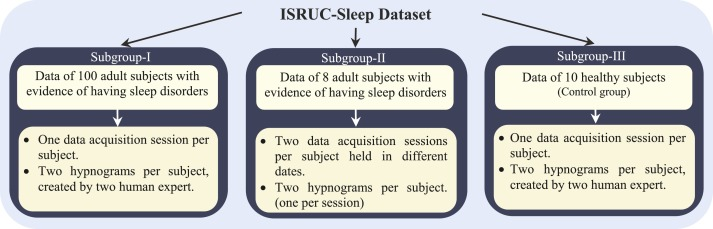

*Figure1: Information about sub-groups of ISRUC-SLEEP Dataset [2]* 

The ISRUC-SLEEP Dataset is written in Excel format, thus we used Pandas library’s ‘read_excel’ function. In the excel file the data is not starting from the first row, therefore we give the header parameter as ‘2’.  

In [ ]:
df = pd.read_excel("Details_subgroup_I_Submission.xlsx",
              header=2,
              sheet_name='Details of SubgroupI')

df_healty = pd.read_excel("Details_subgroup_III_Submission.xlsx",
              header=2,
              sheet_name='SubgroupIII')

The healthy patients do not use any medication, and they do not have any EEG alterations; for concatenating both datasets we added these columns to the dataset of subgroup III.

In [ ]:
df_healty['Medication'] = 'Not use'
df_healty['EEG alterations'] = 'Normal'

sleep_df = df.append(df_healty,ignore_index=True)

The first 5 samples in the dataset.

In [ ]:
sleep_df.head()

,Subject,Age,Sex,Diagnosis,Other problems,Epoches,W%,N1%,N2%,N3%,REM%,Date of recording,W%.1,N1%.1,N2%.1,N3%.1,REM%.1,Medication,EEG alterations
0,1,64,M,SAOS,Depression,880,30.00,8.30,22.05,26.25,13.41,18/5/2009,30.91,4.77,24.09,26.25,13.98,SSRI; trazodona,NaN
1,2,52,M,SAOS,Restless leg syndrome,964,25.41,11.93,35.79,16.29,10.58,2009-08-06 00:00:00,21.99,11.93,44.40,11.10,10.58,NaN,NaN
2,3,38,M,REM Sleep Behaviour Disorder,PLMS,943,14.00,17.50,26.09,18.35,24.07,21/5/2009,12.73,4.45,39.24,15.69,27.89,Risperidona; Tegretol,NaN
3,4,27,M,SRVAS,Epilepsy,963,2.91,6.75,44.24,22.22,23.88,18/6/2009,2.70,3.43,43.61,25.65,24.61,NaN,Paroxistic activity left fronto-parietal
4,5,58,F,SAOS,Insomnia,875,33.83,12.34,30.29,18.74,4.80,25/5/2009,35.66,4.69,35.66,18.86,5.14,BZD,NaN


Sleep is not linear, over the course of the night, the total sleep is composed of different stages. A person goes through these different stages multiple times a night. [25] 

NREM:
N1: The first stage of the sleep cycle is a transition period between wakefulness and sleep. [26]

N2: During stage 2, the body enters a more subdued state including a drop in temperature, relaxed muscles, and slowed breathing and heart rate. At the same time, brain waves show a new pattern and eye movement stops.[25]

N3: Deep, slow brain waves known as delta waves begin to emerge during NREM stage 3 sleep—a stage that is also referred to as delta sleep. This is a period of deep sleep where any noises or activity in the environment may fail to wake the sleeping person. [26]

REM:
During REM sleep, brain activity picks up, nearing levels seen when you’re awake. At the same time, the body experiences atonia, which is a temporary paralysis of the muscles, with two exceptions: the eyes and the muscles that control breathing. Even though the eyes are closed, they can be seen moving quickly, which is how this stage gets its name.

REM sleep is believed to be essential to cognitive functions like memory, learning, and creativity9. REM sleep is known for the most vivid dreams, which is explained by the significant uptick in brain activity. Dreams can occur in any sleep stage, but they are less common and intense in the NREM periods. [25] 

REM sleep comprises about 20 to 25 percent of total sleep in typical healthy adults. [27]


Sleep Stages Table [25]

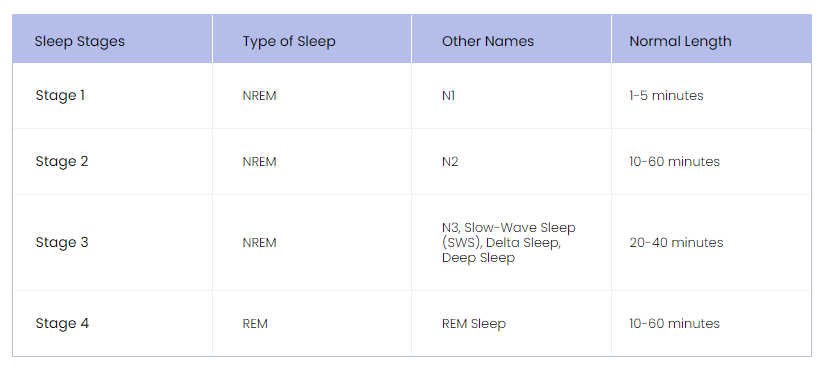

From the ‘info’ we can see that there are some null values and categorical values in the dataset.

In [ ]:
sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Subject            110 non-null    int64  
 1   Age                110 non-null    object 
 2   Sex                110 non-null    object 
 3   Diagnosis          100 non-null    object 
 4   Other problems     47 non-null     object 
 5   Epoches            110 non-null    int64  
 6   W%                 110 non-null    float64
 7   N1%                110 non-null    float64
 8   N2%                110 non-null    float64
 9   N3%                110 non-null    float64
 10  REM%               110 non-null    float64
 11  Date of recording  110 non-null    object 
 12  W%.1               110 non-null    float64
 13  N1%.1              110 non-null    float64
 14  N2%.1              110 non-null    float64
 15  N3%.1              110 non-null    float64
 16  REM%.1             110 non

The summary statistics about numerical data 

In [ ]:
sleep_df.describe()

,Subject,Epoches,W%,N1%,N2%,N3%,REM%,W%.1,N1%.1,N2%.1,N3%.1,REM%.1
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,46.409091,900.054545,22.750455,12.971364,31.383455,19.780182,13.113545,23.746545,10.461727,33.770455,18.344000,13.676455
std,30.563003,64.152604,14.022738,5.483096,8.962737,7.743875,6.306868,14.673772,5.590868,10.503581,7.684624,6.327757
min,1.000000,747.000000,2.910000,1.780000,4.420000,5.170000,0.000000,2.700000,1.470000,5.240000,3.350000,0.000000
25%,18.250000,853.750000,13.000000,8.517500,24.947500,14.467500,9.032500,13.215000,6.267500,26.552500,12.745000,10.392500
50%,45.500000,896.500000,19.545000,12.415000,31.900000,19.180000,13.295000,21.035000,9.750000,33.375000,17.165000,13.830000
75%,72.750000,943.750000,29.955000,17.492500,37.797500,23.367500,16.082500,30.702500,12.750000,41.037500,23.262500,16.562500
max,100.000000,1062.000000,80.490000,27.760000,53.760000,41.120000,37.760000,80.270000,28.000000,59.250000,38.210000,40.020000


For measuring the sleep quality the percentages of sleep stages (W, N1, N2, N3, REM) are important. In our dataset the percentage of stages are measured by two different experts. We created box plots for getting more information about these stages, and comparing the measurements of the two experts. 

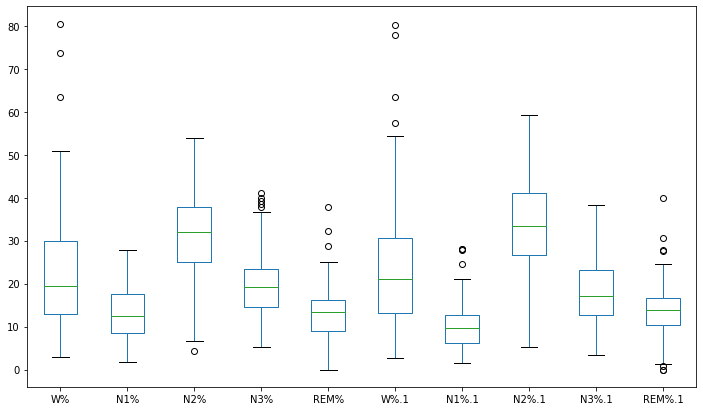

In [ ]:
boxplot = sleep_df.boxplot(column=['W%', 'N1%', 'N2%', 'N3%', 'REM%','W%.1', 'N1%.1', 'N2%.1', 'N3%.1', 'REM%.1'],figsize=(12,7))
plt.grid(False)

## Data Preparation<a class="anchor" id="data_preparation"></a>

While creating models, most of the algorithms cannot handle null values, hence we do not want any Null values in our dataset. However, in the ISRUC-SLEEP Dataset;  if the patient does not have other problems or does not take any medication, the doctors left that feature blank as Null value. Therefore, we filled the Null values with ‘no problem’, or ‘not use’ phases. In addition, the patients in subgroup3 do not have any diagnosis, thus we fill the null values in the ‘Diagnosis’ column as ‘none’.

In [ ]:
sleep_df['Other problems'] = sleep_df['Other problems'].fillna('no problem')
sleep_df['Medication'] = sleep_df['Medication'].fillna('Not use')
sleep_df['Diagnosis'] = sleep_df['Diagnosis'].fillna('None')

It can be seen that now there are no null values in our dataset. 

In [ ]:
sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Subject            110 non-null    int64  
 1   Age                110 non-null    object 
 2   Sex                110 non-null    object 
 3   Diagnosis          110 non-null    object 
 4   Other problems     110 non-null    object 
 5   Epoches            110 non-null    int64  
 6   W%                 110 non-null    float64
 7   N1%                110 non-null    float64
 8   N2%                110 non-null    float64
 9   N3%                110 non-null    float64
 10  REM%               110 non-null    float64
 11  Date of recording  110 non-null    object 
 12  W%.1               110 non-null    float64
 13  N1%.1              110 non-null    float64
 14  N2%.1              110 non-null    float64
 15  N3%.1              110 non-null    float64
 16  REM%.1             110 non

Following, we drop the features that we will not use such as subject ids, or date of recording. 

In [ ]:
sleep_df.drop(['Subject','Date of recording', 'Epoches', 'EEG alterations'], axis=1, inplace=True)

If the patient has more than one problem, or uses more than one medication; the doctors add the multiple features within a one column by separating them with semicolon (;) or comma (,). Because of the form we just explained of the dataset, we could not use the ‘One-Hot Encoding’ function from available libraries for some features. Therefore we created our own ‘One-Hot Encoding’ function for multiple valued features.  
 
This function firstly creates a set of values in the feature column. Since the data contains different spellings of the same value; we apply some string operations to create the set with distinct values. For example in the dataset; the depression problem is written both lower case, and the initial letter is written in capital.  We used the string operations to get these different spellings in one group.  Then the function creates columns for values and fills them according to the patient information.  


In [ ]:
def one_hot_encoding_for_multivalue_features(df, feature, empty_cond, initial):
  organized_df = df

  columns_to_be_added = []
  for index, patient in organized_df.iterrows():
    if patient[feature] != empty_cond:
      # print(patient.other_problems) 
      # values = patient[feature].split(';')
      values = re.split('; |, ',patient[feature])
      columns_to_be_added = columns_to_be_added + values

 # other_problems = (map(lambda x: x.lower(), other_problems))
  for p in range(len(columns_to_be_added)): 
    columns_to_be_added[p] = re.sub("[\(\[].*?[\)\]]", "", columns_to_be_added[p]).lower().strip()   
  columns_set = set(columns_to_be_added)

  print(columns_set)
  print(len(columns_set))

  for fea in list(columns_set):
    name = initial + fea
    organized_df[name] = 0

  for index, patient in organized_df.iterrows():
    if patient[feature] != empty_cond:
      values = re.split('; |, ',patient[feature])
      for v in values:
        name = initial + re.sub("[\(\[].*?[\)\]]", "", v).lower().strip()
        # print(name) 
        organized_df.loc[index, name] = 1

  return organized_df

We used the previous function for encoding the ‘other problems’ and ‘medication’ columns. 

In [ ]:
organized_sleep_df = one_hot_encoding_for_multivalue_features(sleep_df,'Other problems','no problem', 'P_')
organized_sleep_df = one_hot_encoding_for_multivalue_features(organized_sleep_df, 'Medication', 'Not use','M_')


{'les', 'epilepsy', 'avc', 'insomnia', 'chronic respiratoru failure', 'cheyne-stokes', 'shift work', 'affective disorder', 'alcool', 'multiple sclerosis', 'scoliosis', 'central apneas', 'paroxystic activity', 'depression', 'parkinson', 'dementia', 'brain tumour', 's. down', 'restless leg syndrome', 'hypophisis adenoma', 'cheyne-stokes respiration', 'plms', 'chronic respiratory failure', 'renal failure'}
24
{'tricyclic', 'diplexil', 'valproato', 'ropinirol', 'gabapentina', 'trazodona', 'quetiapina', 'bupropion', 'bzd', 'tegretol', 'anti-parkinsonic', 'corticoide', 'ropirinol', 'risperidona', 'mirtazapina', 'ssri'}
16


In the dataset, there is a typo in the spelling of the medicine ‘Ropirinol’; so we corrected it. 

In [ ]:
for row, patient in organized_sleep_df.iterrows():
  if patient['M_ropirinol'] == 1:
    patient['M_ropinirol'] = 1

organized_sleep_df = organized_sleep_df.drop('M_ropirinol', axis=1)

In the Data-Understanding section, we observe that both two the different experts divide patient’s sleep in similar stages. In order to make our data more clear and more understandable, we decided to use the average value of the stages.  


In [ ]:
organized_sleep_df['Average_W%'] = (organized_sleep_df['W%'] + organized_sleep_df['W%.1']) / 2
organized_sleep_df['Average_N1%'] = (organized_sleep_df['N1%'] + organized_sleep_df['N1%.1']) / 2
organized_sleep_df['Average_N2%'] = (organized_sleep_df['N2%'] + organized_sleep_df['N2%.1']) / 2
organized_sleep_df['Average_N3%'] = (organized_sleep_df['N3%'] + organized_sleep_df['N3%.1']) / 2
organized_sleep_df['Average_REM%'] = (organized_sleep_df['REM%'] + organized_sleep_df['REM%.1']) / 2

organized_sleep_df.drop(['Other problems', 'Medication', 'W%', 'N1%','N2%','N3%','REM%','W%.1', 'N1%.1','N2%.1','N3%.1','REM%.1' ], axis=1, inplace=True)


Lastly we used pandas ‘get_dummy’ function for doing One-Hot encoding for the remaining categorical  features.  

In [ ]:
organized_sleep_df = pd.get_dummies(
        data=organized_sleep_df,
        columns=['Diagnosis', 'Sex'],
        prefix=['D', 'S']
    )

organized_sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             110 non-null    object 
 1   P_les                           110 non-null    int64  
 2   P_epilepsy                      110 non-null    int64  
 3   P_avc                           110 non-null    int64  
 4   P_insomnia                      110 non-null    int64  
 5   P_chronic respiratoru failure   110 non-null    int64  
 6   P_cheyne-stokes                 110 non-null    int64  
 7   P_shift work                    110 non-null    int64  
 8   P_affective disorder            110 non-null    int64  
 9   P_alcool                        110 non-null    int64  
 10  P_multiple sclerosis            110 non-null    int64  
 11  P_scoliosis                     110 non-null    int64  
 12  P_central apneas                110 

Sklearn’s KNN Imputer is used to fill the missing values on the age column of our data. Missing age values are shown with a ‘?’, so we started by setting these values to None. After that, KNN Imputer is called. It uses the k-Nearest Neighbors method to replace the missing values in the datasets with the mean value from the k parameter of nearest neighbors found in the training set. 

In [ ]:
organized_sleep_df['Age'].replace({"?": None}, inplace=True)

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
# Impute all the missing data, not just age
imputed_data = imputer.fit_transform(organized_sleep_df)
df_temp = pd.DataFrame(imputed_data)
df_temp.columns = organized_sleep_df.columns
# # Update age column but not others
organized_sleep_df['Age'] = df_temp['Age']
print(organized_sleep_df.iloc[94])

Age                               52.000
P_les                              0.000
P_epilepsy                         0.000
P_avc                              0.000
P_insomnia                         0.000
P_chronic respiratoru failure      0.000
P_cheyne-stokes                    0.000
P_shift work                       0.000
P_affective disorder               0.000
P_alcool                           0.000
P_multiple sclerosis               0.000
P_scoliosis                        0.000
P_central apneas                   0.000
P_paroxystic activity              0.000
P_depression                       0.000
P_parkinson                        0.000
P_dementia                         0.000
P_brain tumour                     0.000
P_s. down                          0.000
P_restless leg syndrome            0.000
P_hypophisis adenoma               0.000
P_cheyne-stokes respiration        0.000
P_plms                             0.000
P_chronic respiratory failure      0.000
P_renal failure 

In [ ]:
print("Number of missing values in age column: ", organized_sleep_df['Age'].isna().sum())

Number of missing values in age column:  0


As we can see, missing values of the age column are filled.

During the examination of our dataset, we saw that most of our patients' sleep cycles include less than 20-25% REM sleep, which is the normal amount of REM sleep for healthy adults. It may be an indication to the sleep quality, so we decided to consider REM percentage as a measure for sleep quality. We checked the patient distributions with different thresholds of the amount of REM sleep they get and decided to separate them into 5 groups.

In [ ]:
REM = {} 
REM['group -1'] = 0
REM['group 0'] = 0
REM['group 1'] = 0
REM['group 2'] = 0
REM['group 3'] = 0
rem_group = list()
for index, row in organized_sleep_df.iterrows():
  if row['Average_REM%'] <= 10:
    rem_group.append(-1)
    REM['group -1'] = REM['group -1'] + 1
  elif (row['Average_REM%'] > 10) & (row['Average_REM%'] <= 15):
    rem_group.append(0)
    REM['group 0'] = REM['group 0'] + 1
  elif (row['Average_REM%'] > 15) & (row['Average_REM%'] < 20):
    rem_group.append(1)
    REM['group 1'] = REM['group 1'] + 1
  elif (row['Average_REM%'] >= 20) & (row['Average_REM%'] <= 25):
     rem_group.append(2)
     REM['group 2'] = REM['group 2'] + 1
  else:
    rem_group.append(3)
    REM['group 3'] = REM['group 3'] + 1

organized_sleep_df['rem_group'] = rem_group
organized_sleep_df.info()

print(REM)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             110 non-null    float64
 1   P_les                           110 non-null    int64  
 2   P_epilepsy                      110 non-null    int64  
 3   P_avc                           110 non-null    int64  
 4   P_insomnia                      110 non-null    int64  
 5   P_chronic respiratoru failure   110 non-null    int64  
 6   P_cheyne-stokes                 110 non-null    int64  
 7   P_shift work                    110 non-null    int64  
 8   P_affective disorder            110 non-null    int64  
 9   P_alcool                        110 non-null    int64  
 10  P_multiple sclerosis            110 non-null    int64  
 11  P_scoliosis                     110 non-null    int64  
 12  P_central apneas                110 

## Modeling<a class="anchor" id="modeling"></a>

In [ ]:
y = organized_sleep_df['rem_group']
X = organized_sleep_df.drop(['rem_group'], axis=1)

In the previous section, we splitted our data to 5 different classes according to the REM amount. We also want to cluster our data. K-means is a well-known and mostly used clustering algorithm, and it was suitable for our dataset, therefore, we clustered our data with K-Means. 

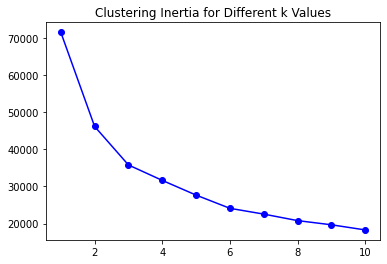

In [ ]:
def finding_K(samples, title):
    inetria = []
    for k in range(1,11):
        model = KMeans(n_clusters = k)
        model.fit(samples)
        inetria.append(model.inertia_)

    x = list(range(1, 11))
    plt.plot(x,inetria, marker= 'o', color='b')
    plt.title(title)
    plt.show()

finding_K(X, "Clustering Inertia for Different k Values")

Primary, we checked the inertia values for different k-values, and we see that 5 clusters is really suitable for our dataset. Secondly, we create 5 clusters with the K-means algorithm. 

In [ ]:
def KMeans_clustring(k, samples):
    model = KMeans(n_clusters=k)
    model.fit(samples)
    labels = model.labels_

    return labels

# cluster_data_frame = organized_sleep_df[important_features]
clusters = KMeans_clustring(5, X)

In [ ]:
rem_X = organized_sleep_df.drop(['Age', 'rem_group','Average_W%', 'Average_N1%', 'Average_N2%', 'Average_N3%', 'Average_REM%'], axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def feature_importance(X, y):
  feature_names = X.columns # [f"feature {i}" for i in range(X.shape[1])]
  forest = RandomForestClassifier(random_state=42)
  forest.fit(X, y)

  importances = forest.feature_importances_
  std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

  return feature_names, importances

cluster_feature_names, cluster_importances = feature_importance(rem_X, clusters)
rem_feature_names, rem_importances = feature_importance(rem_X, y)

Text(0.5, 1.0, 'Cluster Feature Importances')

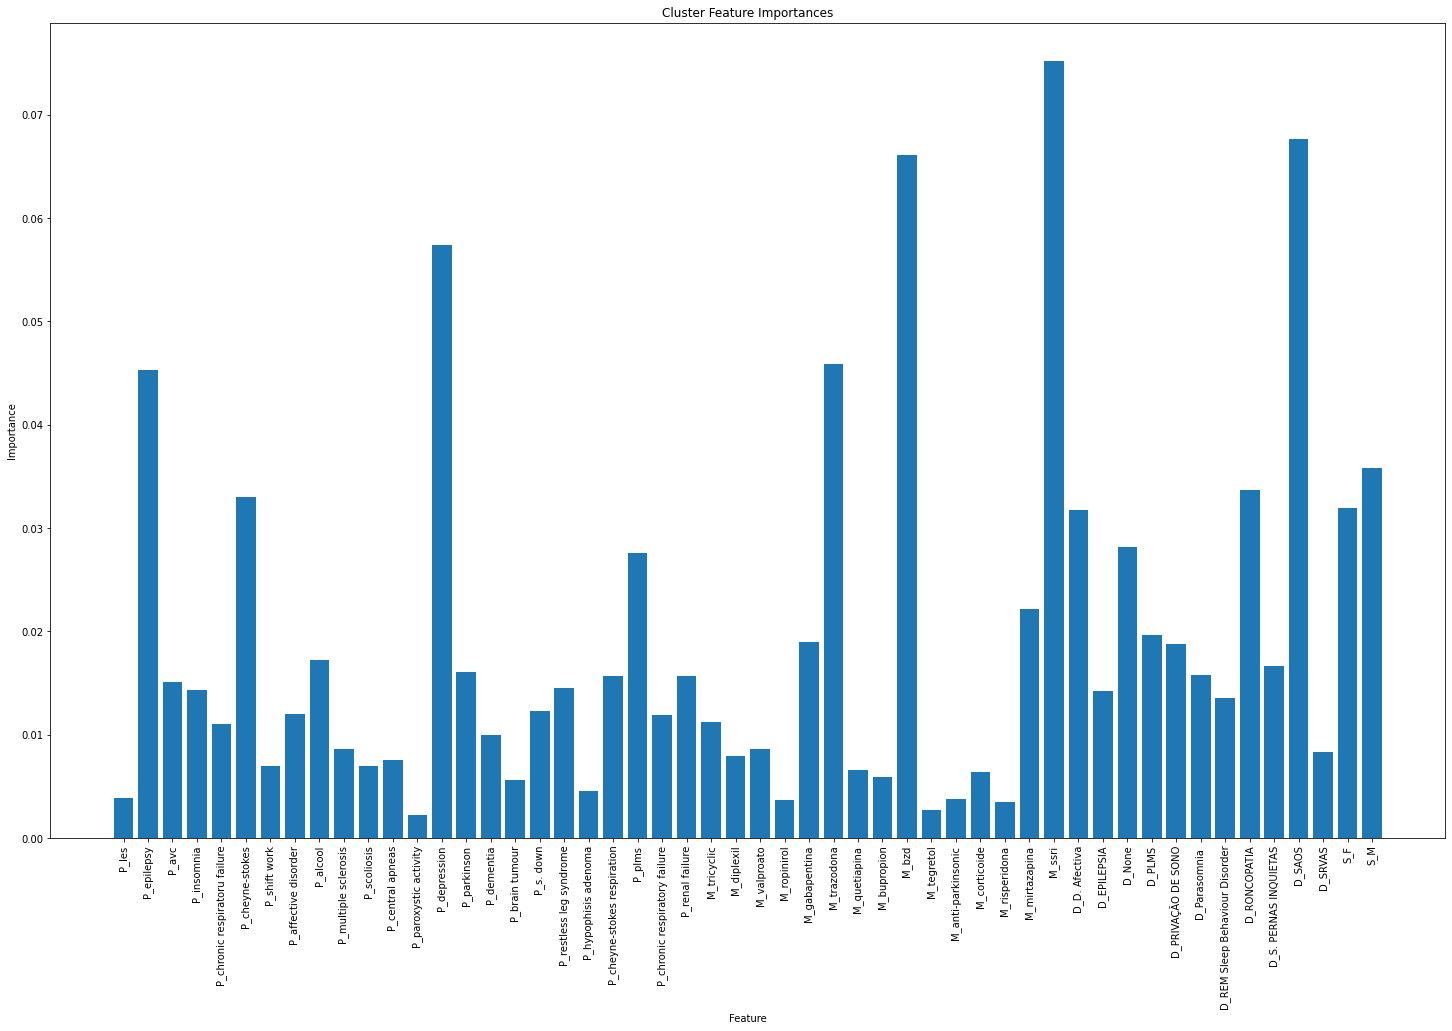

In [ ]:
# forest_importances = pd.Series(rem_importances, index=feature_names)


x_values = list(range(len(cluster_importances)))
plt.figure(figsize=(25,15))
plt.bar(x_values, cluster_importances, orientation = 'vertical')
plt.xticks(x_values, cluster_feature_names, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Cluster Feature Importances')

Text(0.5, 1.0, 'Rem Feature Importances')

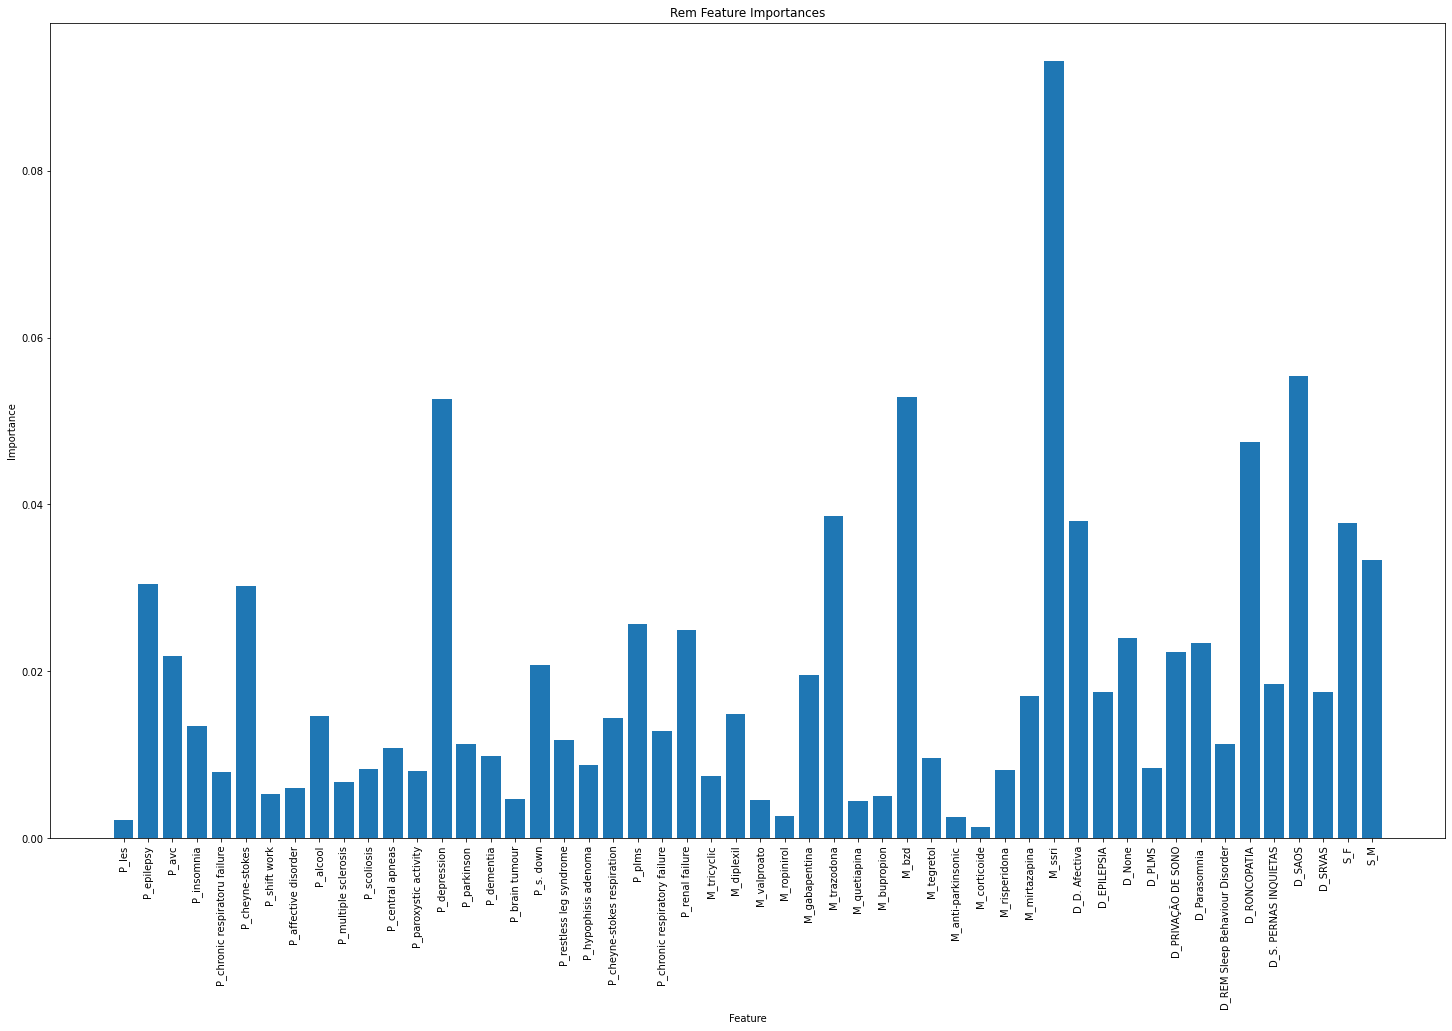

In [ ]:
x_values = list(range(len(rem_importances)))
plt.figure(figsize=(25,15))
plt.bar(x_values, rem_importances, orientation = 'vertical')
plt.xticks(x_values, rem_feature_names, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Rem Feature Importances')

## Evaluation<a class="anchor" id="evaluation"></a>

Let us obtain the most important features of the sleep quality.

In [ ]:
def most_important_features(importances, feature_names):
  important_features = {}
  for i in range(len(importances)):
    if importances[i] >= 0.030:
      important_features[feature_names[i]] = importances[i]

  print(important_features)
  return important_features


{'P_epilepsy': 0.045322280137923866, 'P_cheyne-stokes': 0.033039282732809816, 'P_depression': 0.05740641098316119, 'M_trazodona': 0.04588049512004631, 'M_bzd': 0.06605642308673618, 'M_ssri': 0.07515395447102328, 'D_D. Afectiva': 0.03176354992379976, 'D_RONCOPATIA': 0.03369500328403602, 'D_SAOS': 0.06762420755389226, 'S_F': 0.03195702698539321, 'S_M': 0.03580827966395807}


<BarContainer object of 11 artists>

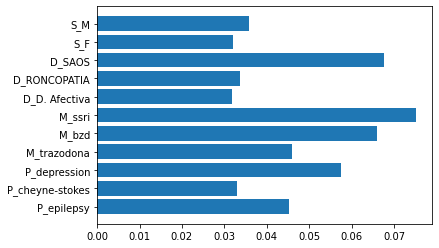

In [ ]:
cluster_important_features = most_important_features(cluster_importances, cluster_feature_names)
plt.barh(list(cluster_important_features.keys()), list(cluster_important_features.values()))

{'P_epilepsy': 0.03047375115114683, 'P_cheyne-stokes': 0.030226127856300314, 'P_depression': 0.052657280614553804, 'M_trazodona': 0.038606885267210435, 'M_bzd': 0.052887325315718686, 'M_ssri': 0.09310262765011029, 'D_D. Afectiva': 0.03801820799142384, 'D_RONCOPATIA': 0.04751250047851949, 'D_SAOS': 0.05543011874465634, 'S_F': 0.037800996205751454, 'S_M': 0.033329095202912364}


<BarContainer object of 11 artists>

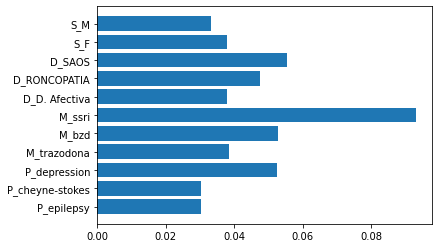

In [ ]:
rem_important_features = most_important_features(rem_importances, rem_feature_names)
plt.barh(list(rem_important_features.keys()), list(rem_important_features.values()))

Lastly, we find feature importances with Random Forest Classifier for both of our implementations. As a result we observed that the most important features in both clusters are similar. 

We can see that different parameters are important and must be considered when evaluating the sleep quality of a patient. According to the results we obtained from our model, here are some of the most important parameters that affect sleep quality. 

####Gender and Age
There are many studies that try to explain the effects of gender on sleep quality. It is known that gender also affects the diseases a person may have more tendency to catch different diseases. These diseases or life stages affect the sleep quality as well. For example, women who entered menopause may have trouble sleeping. [3] 

According to a study done in Spain, the prevalence of poor sleep quality is high among adults, especially women. This paper also states that there is a direct relationship between age and deterioration in the quality of sleep, and this relationship also appears to be more consistent in women. It is also shown that the amount of sleep men and women get are not very different, but it is the quality of sleep that depends on the gender of the subjects. [4]

A study done in 2006 also shows that women are 1.41 times more predisposed to suffer from insomnia than men at all ages but especially at advanced ages.[5]


####SAOS: Sleep Apnea
Sleep apnea is a sleep disorder in which pauses in breathing or periods of shallow breathing during sleep occur more often than normal. [6]  It has been linked to obesity, having a large neck, age, having other family members with sleep apnea, smoking and drinking alcohol, having large tonsils or adenoids, and sleeping on your back. [7] 

As stated before, it causes a patient to have trouble breathing while sleeping, hence it affects the sleep quality. 


####Roncopatia: Snoring
Snoring is the vibration of respiratory structures and the resulting sound due to obstructed air movement during breathing while sleeping.[8] Snoring can be a sign of sleep apnea (SAOS for our dataset). Its causes are similar to sleep apnea’s causes. Even if it usually does not cause a patient to stop breathing entirely, it lowers sleep quality, because patients wake themselves up without realizing it. [9]

####D. Afectiva: Bipolar Disorder
Bipolar disorder is a mental health condition that affects your moods, which can swing from 1 extreme to another. It used to be known as manic depression. [10]  Bipolar disorder frequently includes sleep disturbance. [11] Hence, the patients with bipolar disorder are more likely the have poorer sleep quality than healthy people.


####SSRI: Selective serotonin reuptake inhibitors
They're mainly prescribed to treat depression, particularly persistent or severe cases. SSRIs are usually the first choice medicine for depression because they generally have fewer side effects than most other types of antidepressant. It's thought that SSRIs work by increasing serotonin levels in the brain.It's thought to have a good influence on mood, emotion and sleep.  [12] 


####BZD: Benzodiazepines
They are prescribed to treat conditions such as anxiety, insomnia, and seizures.[13] Although they are given to patients to treat insomnia, they may lead to adverse effects in adults with insomnia as well. [14]


####Trazodona: Trazodone
It is an antidepressant medication which is used to treat major depressive disorder, anxiety disorders, and difficulties with sleep. Trazodone was the second-most prescribed agent for insomnia in the early 2000s, though most studies of trazodone for treatment of sleep disturbances have been in depressed individuals. [15] 


####Depression
Sleep disturbances are an integral aspect of depression. [16] People with depression may find it difficult to fall asleep and stay asleep during the night. They can also have excessive daytime sleepiness or even sleep too much.[17] Hence, their sleep quality may decrease. Depression and sleep quality are dependent on each other: Poor sleep quality may cause depression and depression may cause poor sleep quality.

It is also important to note that “emotional memories” are processed during the REM stage of sleep. [18] Depression can cause “negative emotional memories” to be processed and make patients wake up more frequently or have trouble sleeping. 


####Cheyne-Stokes Syndrome
Cheyne-Stokes respirations are a rare abnormal breathing pattern that can occur while awake but usually occurs during sleep. The pattern involves a period of fast, shallow breathing followed by slow, heavier breathing and moments without any breath at all, similar to sleep apnea. [19] It may be directly related to sleep apnea and snoring. It causes patients to wake up frequently during the night and decreases the quality of sleep.


####Epilepsy
Epilepsy is the condition of recurrent, unprovoked seizures. Epilepsy has numerous causes, each reflecting underlying brain dysfunction. [20] As with all medications, anti-epileptic drugs (AEDs) can cause side effects for some people. AEDs may have different effects on sleep, and this can vary from person to person, depending on the dose. Some AEDs are classed as sedatives and can cause tiredness. Some can cause insomnia or disrupted sleep. However some AEDs can help to improve the quality of sleep by increasing the length of deep sleep. [21] 


## References<a class="anchor" id="references"></a>

List all the sources you used during your work.
This includes jupyter notebooks you found on Internet.
Remeber, your work may not be an original one. However, this document must be genuine. Copy and paste kind of deliveries will be punished badly.

[1] The image is taken from:
https://healthblog.uofmhealth.org/wellness-prevention/do-sleep-trackers-work-pros-and-cons-to-know

[2] https://paperswithcode.com/dataset/isruc-sleep

[3] https://www.sleepfoundation.org/women-sleep/menopause-and-sleep 

[4] https://www.sciencedirect.com/science/article/pii/S0213911116301182 

[5] https://academic.oup.com/sleep/article/29/1/85/2708069?login=true 

[6] https://www.nhlbi.nih.gov/health/sleep-apnea 

[7] https://www.nhs.uk/conditions/sleep-apnoea/ 

[8] https://en.wikipedia.org/wiki/Snoring 

[9] https://www.sleepcycle.com/snoring/long-term-snoring-health-implications/ 

[10] https://www.nhs.uk/mental-health/conditions/bipolar-disorder/overview/ 

[11] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3549461/ 

[12] https://www.nhs.uk/mental-health/talking-therapies-medicine-treatments/medicines-and-psychiatry/ssri-antidepressants/overview/ 

[13] https://en.wikipedia.org/wiki/Benzodiazepine 

[14] https://ebmh.bmj.com/content/3/3/81 

[15] https://en.wikipedia.org/wiki/Trazodone

[16] https://www.tandfonline.com/doi/full/10.31887/DCNS.2006.8.2/mthase 

[17] https://www.sleepfoundation.org/mental-health/depression-and-sleep 

[18] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2890316/ 

[19] https://www.sleepfoundation.org/sleep-apnea/cheyne-stokes-respirations 

[20] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4448698/ 

[21] https://epilepsysociety.org.uk/living-epilepsy/wellbeing/sleep-epilepsy

[22] https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.481.3378&rep=rep1&type=pdf 

[23] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5548844/

[24] https://link.springer.com/article/10.2165/00003495-200565070-00003 

[25] https://www.sleepfoundation.org/stages-of-sleep

[26] https://www.verywellhealth.com/the-four-stages-of-sleep-2795920 

[27] https://healthysleep.med.harvard.edu/healthy/science/what/sleep-patterns-rem-nrem 

##Thanks
Special thanks to Dr. Ö. Pınar Tayfun and Stj. Dr. İrem İvegen who answered our questions about the topics requiring medical knowledge and helped us understand the medical-side of this project.


**Disclaimer!** <font color='grey'>This notebook was prepared by Ece Kunduracioglu, Ece Korkmaz as a term project for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>